<a href="https://colab.research.google.com/github/Ajisco/azure-portfolio/blob/main/opt5_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kagglehub matplotlib torch

# !git clone -q https://github.com/Google-Health/imaging-research.git
!pip install -q imaging-research/cxr-foundation/

!pip install -q imblearn

import kagglehub
kagglehub.login()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import os


bardiakh_mimic_cxr_embedding_path = kagglehub.dataset_download('bardiakh/mimic-cxr-embedding')
mohammadrezachavoshi_chexpert_path = kagglehub.dataset_download('mohammadrezachavoshi/chexpert')
mohammadrezachavoshi_metadata_path = kagglehub.dataset_download('mohammadrezachavoshi/metadata')
mohammadrezachavoshi_splits_path = kagglehub.dataset_download('mohammadrezachavoshi/splits')
mohammadrezachavoshi_mimic_pth_path = kagglehub.dataset_download('mohammadrezachavoshi/mimic-pth')

print('Data source import complete.')


print("MIMIC CXR embedding path:", bardiakh_mimic_cxr_embedding_path)
print("CheXpert path:", mohammadrezachavoshi_chexpert_path)
print("Metadata path:", mohammadrezachavoshi_metadata_path)
print("Splits path:", mohammadrezachavoshi_splits_path)
print("MIMIC pth path:", mohammadrezachavoshi_mimic_pth_path)

# Variables for quick access
mimic_cxr_embedding_path = "/home/aaajiba/.cache/kagglehub/datasets/bardiakh/mimic-cxr-embedding/versions/1"
chexpert_path = "/home/aaajiba/.cache/kagglehub/datasets/mohammadrezachavoshi/chexpert/versions/1"
metadata_path = "/home/aaajiba/.cache/kagglehub/datasets/mohammadrezachavoshi/metadata/versions/1"
splits_path = "/home/aaajiba/.cache/kagglehub/datasets/mohammadrezachavoshi/splits/versions/1"
mimic_pth_path = "/home/aaajiba/.cache/kagglehub/datasets/mohammadrezachavoshi/mimic-pth/versions/1"

# Define the file paths using the variables for quick access
metadata_path = f"{metadata_path}/mimic-cxr-2.0.0-metadata.csv"
split_path = f"{splits_path}/mimic-cxr-2.0.0-split.csv"
chexpert_path = f"{chexpert_path}/mimic-cxr-2.0.0-chexpert.csv"

# Read the CSV files
metadata_df = pd.read_csv(metadata_path)
split_df = pd.read_csv(split_path)
chexpert_df = pd.read_csv(chexpert_path)


# Define the file path for embeddings
embeddings_path = f"{mimic_cxr_embedding_path}/physionet.org/content/image-embeddings-mimic-cxr/get-zip/1.0/embedding/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/SHA256SUMS.txt"

# Read the embeddings file
df_embeddings = pd.read_csv(embeddings_path, delimiter=" ", header=None, skiprows=[0])



FILE_PATTERN = re.compile(r"files/(?:\w+)/p(?P<subject_id>\w+)/s(?P<study_id>\w+)/(?P<dicom_id>[\w-]+)\.tfrecord")

def parse_file_pattern(file_path: str):
    """
    Extracts the subject_id, study_id, and dicom_id
    from the full file path string.
    """
    match = FILE_PATTERN.fullmatch(file_path)
    if not match:
        raise Exception(f"Failed to match file path: {file_path}")
    return (int(match[1]), int(match[2]), match[3])

# Create additional columns from file path components
df_embeddings = df_embeddings[[1]]
df_embeddings.rename(columns={1: "embedding_file"}, inplace=True)
df_embeddings[["subject_id","study_id", "dicom_id"]] = df_embeddings.apply(
    lambda x: parse_file_pattern(x["embedding_file"]), axis=1, result_type="expand")


# Data preprocessing
df_labels = split_df.merge(chexpert_df, on=['subject_id', 'study_id'])
df_labels = df_labels.merge(metadata_df, on=['dicom_id'])
df_labels = df_embeddings.merge(df_labels, on=['dicom_id'], how='left')

embedding_base_path = "/home/aaajiba/.cache/kagglehub/datasets/mohammadrezachavoshi/mimic-pth/versions/1/pth_embeddings"


# Get the number of available CPU cores
num_workers = os.cpu_count()


Data source import complete.
MIMIC CXR embedding path: /home/aaajiba/.cache/kagglehub/datasets/bardiakh/mimic-cxr-embedding/versions/1
CheXpert path: /home/aaajiba/.cache/kagglehub/datasets/mohammadrezachavoshi/chexpert/versions/1
Metadata path: /home/aaajiba/.cache/kagglehub/datasets/mohammadrezachavoshi/metadata/versions/1
Splits path: /home/aaajiba/.cache/kagglehub/datasets/mohammadrezachavoshi/splits/versions/1
MIMIC pth path: /home/aaajiba/.cache/kagglehub/datasets/mohammadrezachavoshi/mimic-pth/versions/1


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report
import logging
import math
import torch
from torchvision import transforms
from pathlib import Path

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


def prepare_data(df_labels):
    """Prepare data with patient-level splitting"""
    # Remove uncertain/missing values
    df_filtered = df_labels[
        (df_labels['Cardiomegaly'].notna()) &
        (df_labels['Cardiomegaly'] != -1)
    ].copy()

    # Get unique patient IDs
    patient_ids = df_filtered['subject_id'].unique()

    # Split patient IDs
    train_size = int(0.7 * len(patient_ids))
    val_size = int(0.15 * len(patient_ids))

    # Shuffle patient IDs
    np.random.shuffle(patient_ids)
    train_patients = patient_ids[:train_size]
    val_patients = patient_ids[train_size:train_size + val_size]
    test_patients = patient_ids[train_size + val_size:]

    # Split data by patient ID
    train_df = df_filtered[df_filtered['subject_id'].isin(train_patients)]
    val_df = df_filtered[df_filtered['subject_id'].isin(val_patients)]
    test_df = df_filtered[df_filtered['subject_id'].isin(test_patients)]

    return train_df, val_df, test_df


def load_embedding(file_path):
    """Load and preprocess embedding"""
    try:
        embedding = torch.load(file_path, weights_only=True).float()
        embedding = (embedding - embedding.mean()) / embedding.std()
        return embedding.numpy()
    except Exception as e:
        #logger.error(f"Error loading embedding {file_path}: {e}")
        return None

def get_embeddings_and_labels(df, embedding_base_path):
    """Get embeddings and labels from DataFrame"""
    embeddings = []
    labels = []

    for _, row in df.iterrows():
        # Convert subject_id and study_id to strings
        subject_id = str(row['subject_id'])
        study_id = str(row['study_id'])

        embedding_path = os.path.join(
            embedding_base_path,
            'files',
            f"p{subject_id[:2]}",
            f"p{subject_id}",
            f"s{study_id}",  # Add 's' prefix
            f"{row['dicom_id']}.pth"
        )

        # Add logging to debug path construction
        #logger.debug(f"Trying to load embedding from: {embedding_path}")

        embedding = load_embedding(embedding_path)
        if embedding is not None:
            embeddings.append(embedding)
            labels.append(row['Cardiomegaly'])

    if not embeddings:
        #logger.warning(f"No valid embeddings found for {len(df)} images")
        return np.array([]), np.array([])

    return np.array(embeddings), np.array(labels)

=== Raw Data Analysis ===


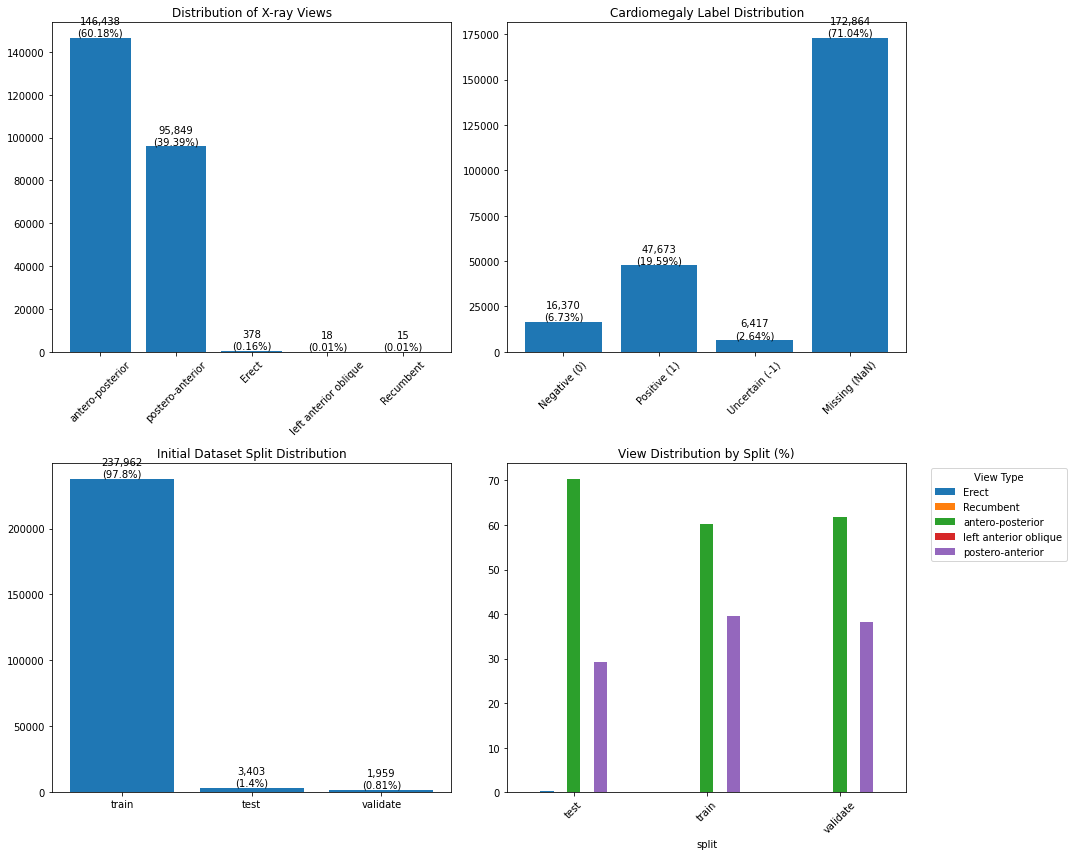


=== Raw Data Statistics ===
Total samples: 243,324

Split Distribution:
train: 237,962 (97.8%)
test: 3,403 (1.4%)
validate: 1,959 (0.81%)

View Distribution:
antero-posterior: 146,438 (60.18%)
postero-anterior: 95,849 (39.39%)
Erect: 378 (0.16%)
left anterior oblique: 18 (0.01%)
Recumbent: 15 (0.01%)

Cardiomegaly Label Distribution:
Negative (0): 16,370 (6.73%)
Positive (1): 47,673 (19.59%)
Uncertain (-1): 6,417 (2.64%)
Missing (NaN): 172,864 (71.04%)





=== Processed Data Analysis ===

=== Processed Data Analysis ===
Total samples after processing: 64,043

View Distribution in Processed Data:
antero-posterior: 47,951 (74.87%)
postero-anterior: 15,765 (24.62%)
Erect: 72 (0.11%)
Recumbent: 6 (0.01%)
left anterior oblique: 2 (0.0%)

AP Split Distribution:
Train: 33,548 (69.96%)
Val: 6,995 (14.59%)
Test: 7,408 (15.45%)

PA Split Distribution:
Train: 10,963 (69.54%)
Val: 2,363 (14.99%)
Test: 2,439 (15.47%)


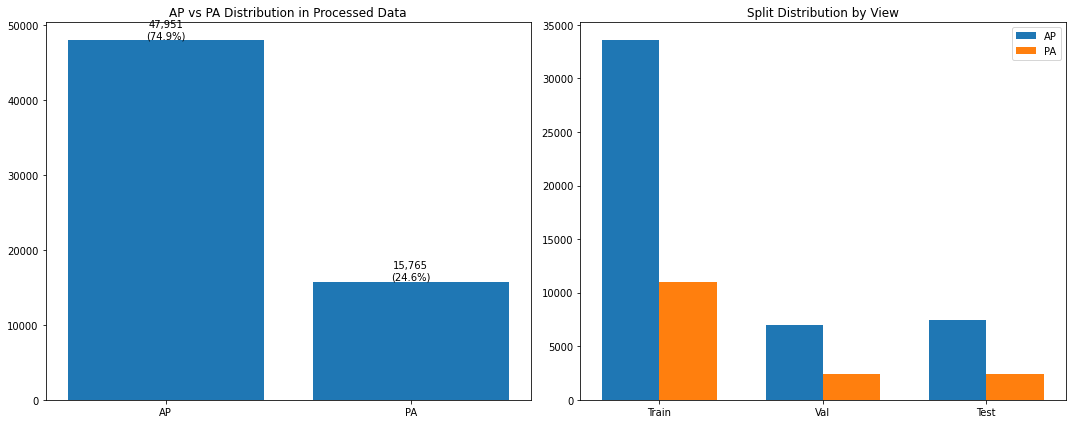

In [ ]:
def analyze_raw_data(df_labels):
    """Analyze dataset distributions before any processing"""
    total_samples = len(df_labels)

    # Create subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # View distribution
    view_counts = df_labels['ViewCodeSequence_CodeMeaning'].value_counts()
    view_percentages = (view_counts / total_samples * 100).round(2)
    axes[0,0].bar(view_counts.index, view_counts.values)
    axes[0,0].set_title('Distribution of X-ray Views')
    axes[0,0].tick_params(axis='x', rotation=45)
    for i, (count, percentage) in enumerate(zip(view_counts, view_percentages)):
        axes[0,0].text(i, count, f'{count:,}\n({percentage}%)',
                      ha='center', va='bottom')

    # Cardiomegaly distribution including all values
    cardio_counts = df_labels['Cardiomegaly'].value_counts(dropna=False)
    cardio_percentages = (cardio_counts / total_samples * 100).round(2)

    cardio_labels = ['Negative (0)', 'Positive (1)', 'Uncertain (-1)', 'Missing (NaN)']
    cardio_values = [
        cardio_counts.get(0, 0),
        cardio_counts.get(1, 0),
        cardio_counts.get(-1, 0),
        cardio_counts.get(np.nan, 0)
    ]
    cardio_pcts = [
        cardio_percentages.get(0, 0),
        cardio_percentages.get(1, 0),
        cardio_percentages.get(-1, 0),
        cardio_percentages.get(np.nan, 0)
    ]

    axes[0,1].bar(range(len(cardio_labels)), cardio_values)
    axes[0,1].set_title('Cardiomegaly Label Distribution')
    axes[0,1].set_xticks(range(len(cardio_labels)))
    axes[0,1].set_xticklabels(cardio_labels, rotation=45)
    for i, (count, percentage) in enumerate(zip(cardio_values, cardio_pcts)):
        axes[0,1].text(i, count, f'{count:,}\n({percentage}%)',
                      ha='center', va='bottom')

    # Initial data split distribution
    split_counts = df_labels['split'].value_counts()
    split_percentages = (split_counts / total_samples * 100).round(2)
    axes[1,0].bar(split_counts.index, split_counts.values)
    axes[1,0].set_title('Initial Dataset Split Distribution')
    for i, (count, percentage) in enumerate(zip(split_counts, split_percentages)):
        axes[1,0].text(i, count, f'{count:,}\n({percentage}%)',
                      ha='center', va='bottom')

    # View distribution by split
    split_view_data = pd.crosstab(df_labels['split'],
                                 df_labels['ViewCodeSequence_CodeMeaning'],
                                 normalize='index') * 100
    split_view_data.plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('View Distribution by Split (%)')
    axes[1,1].legend(title='View Type', bbox_to_anchor=(1.05, 1))
    axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\n=== Raw Data Statistics ===")
    print(f"Total samples: {total_samples:,}")
    print("\nSplit Distribution:")
    for split, count in split_counts.items():
        print(f"{split}: {count:,} ({split_percentages[split]}%)")
    print("\nView Distribution:")
    for view, count in view_counts.items():
        print(f"{view}: {count:,} ({view_percentages[view]}%)")
    print("\nCardiomegaly Label Distribution:")
    for label, count, pct in zip(cardio_labels, cardio_values, cardio_pcts):
        print(f"{label}: {count:,} ({pct}%)")

def analyze_processed_data(train_df, val_df, test_df):
    """Analyze processed data with focus on AP/PA distribution"""
    total_processed = len(train_df) + len(val_df) + len(test_df)

    print("\n=== Processed Data Analysis ===")
    print(f"Total samples after processing: {total_processed:,}")

    # Overall AP/PA distribution in processed data
    view_counts = pd.concat([train_df, val_df, test_df])['ViewCodeSequence_CodeMeaning'].value_counts()
    view_percentages = (view_counts / total_processed * 100).round(2)
    print("\nView Distribution in Processed Data:")
    for view, count in view_counts.items():
        print(f"{view}: {count:,} ({view_percentages[view]}%)")

    # Split distribution for AP
    ap_train = train_df[train_df['ViewCodeSequence_CodeMeaning'] == 'antero-posterior']
    ap_val = val_df[val_df['ViewCodeSequence_CodeMeaning'] == 'antero-posterior']
    ap_test = test_df[test_df['ViewCodeSequence_CodeMeaning'] == 'antero-posterior']
    total_ap = len(ap_train) + len(ap_val) + len(ap_test)

    print(f"\nAP Split Distribution:")
    print(f"Train: {len(ap_train):,} ({len(ap_train)/total_ap*100:.2f}%)")
    print(f"Val: {len(ap_val):,} ({len(ap_val)/total_ap*100:.2f}%)")
    print(f"Test: {len(ap_test):,} ({len(ap_test)/total_ap*100:.2f}%)")

    # Split distribution for PA
    pa_train = train_df[train_df['ViewCodeSequence_CodeMeaning'] == 'postero-anterior']
    pa_val = val_df[val_df['ViewCodeSequence_CodeMeaning'] == 'postero-anterior']
    pa_test = test_df[test_df['ViewCodeSequence_CodeMeaning'] == 'postero-anterior']
    total_pa = len(pa_train) + len(pa_val) + len(pa_test)

    print(f"\nPA Split Distribution:")
    print(f"Train: {len(pa_train):,} ({len(pa_train)/total_pa*100:.2f}%)")
    print(f"Val: {len(pa_val):,} ({len(pa_val)/total_pa*100:.2f}%)")
    print(f"Test: {len(pa_test):,} ({len(pa_test)/total_pa*100:.2f}%)")

    # Visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Overall AP/PA distribution
    ax1.bar(['AP', 'PA'], [total_ap, total_pa])
    ax1.set_title('AP vs PA Distribution in Processed Data')
    for i, (view, count) in enumerate(zip(['AP', 'PA'], [total_ap, total_pa])):
        percentage = count/total_processed * 100
        ax1.text(i, count, f'{count:,}\n({percentage:.1f}%)',
                ha='center', va='bottom')

    # Split distribution by view
    x = np.arange(3)
    width = 0.35

    ap_splits = [len(ap_train), len(ap_val), len(ap_test)]
    pa_splits = [len(pa_train), len(pa_val), len(pa_test)]

    rects1 = ax2.bar(x - width/2, ap_splits, width, label='AP')
    rects2 = ax2.bar(x + width/2, pa_splits, width, label='PA')

    ax2.set_title('Split Distribution by View')
    ax2.set_xticks(x)
    ax2.set_xticklabels(['Train', 'Val', 'Test'])
    ax2.legend()

    plt.tight_layout()
    plt.show()


# Analyze raw data
print("=== Raw Data Analysis ===")
analyze_raw_data(df_labels)

print("\n\n=================================\n\n")

# Prepare and analyze processed data
train_df, val_df, test_df = prepare_data(df_labels)
print("\n=== Processed Data Analysis ===")
analyze_processed_data(train_df, val_df, test_df)



=== Raw Embeddings Analysis ===
Loading raw embeddings...


100%|██████████| 5000/5000 [00:05<00:00, 903.14it/s] 



Total embeddings analyzed: 5000
Embedding dimension: (1376,)

Embedding Statistics:
Mean: -0.1046
Std: 1.5727
Min: -17.6759
Max: 14.3095

View Distribution:
Erect: 6 (0.12%)
antero-posterior: 3050 (61.00%)
nan: 11 (0.22%)
postero-anterior: 1933 (38.66%)

Cardiomegaly Status Distribution:
Status -1.0: 134 (2.68%)
Status 0.0: 349 (6.98%)
Status 1.0: 986 (19.72%)
Status NaN: 3531 (70.62%)


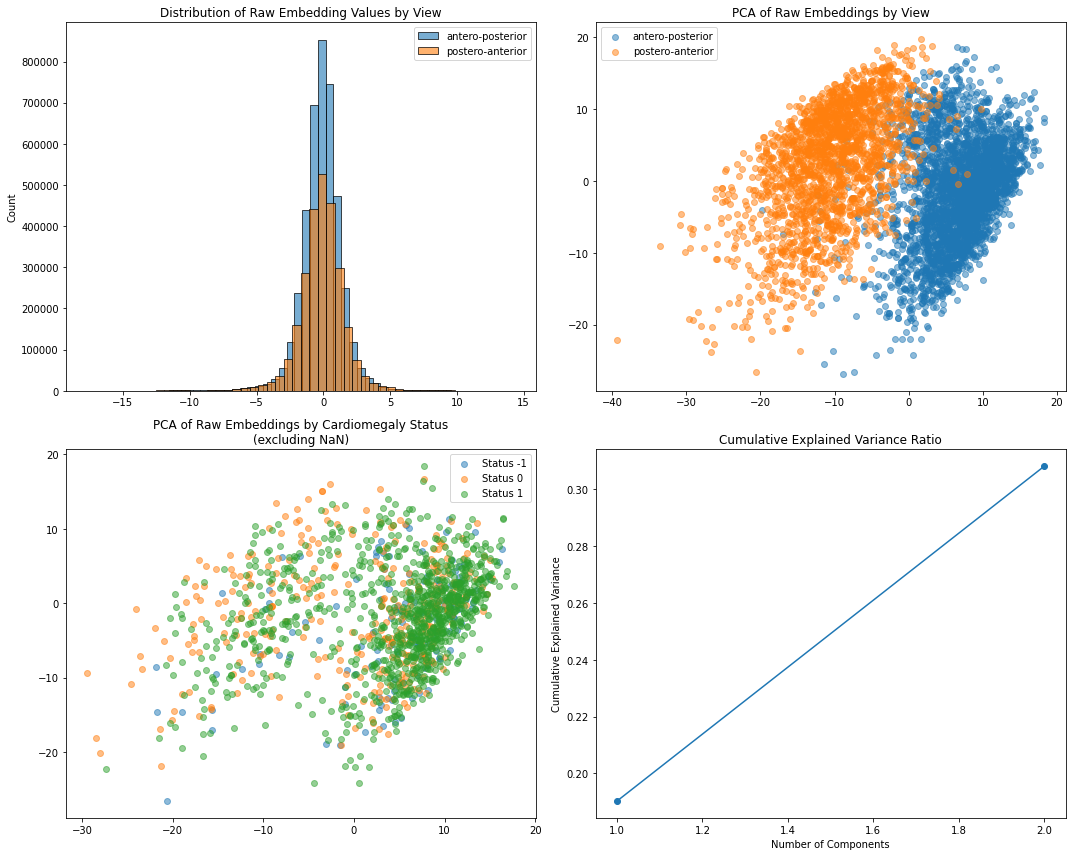


Embedding Statistics by View (AP/PA only):

antero-posterior:
Cardiomegaly Status Distribution:
  Status NaN: 1942 (63.67%)
  Status 1.0: 782 (25.64%)
  Status 0.0: 216 (7.08%)
  Status -1.0: 110 (3.61%)

Embedding Statistics:
  Mean: -0.1072
  Std: 1.4962
  Min: -16.2257
  Max: 13.0650

postero-anterior:
Cardiomegaly Status Distribution:
  Status NaN: 1581 (81.79%)
  Status 1.0: 201 (10.40%)
  Status 0.0: 128 (6.62%)
  Status -1.0: 23 (1.19%)

Embedding Statistics:
  Mean: -0.1004
  Std: 1.6864
  Min: -17.6759
  Max: 14.3095


/tmp/ipykernel_1404738/1377658315.py:138: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  status_counts = pd.value_counts(cardio_status_clean[view_mask], dropna=False)


In [ ]:
import seaborn as sns
from sklearn.decomposition import PCA

def load_raw_embeddings(df_labels, embedding_base_path, sample_size=5000):
    """Load embeddings without normalization"""
    # Sample data for analysis
    sampled_df = df_labels.sample(n=min(sample_size, len(df_labels)), random_state=42)

    embeddings = []
    views = []
    cardio_status = []

    print("Loading raw embeddings...")
    for _, row in tqdm(sampled_df.iterrows(), total=len(sampled_df)):
        embedding_path = os.path.join(
            embedding_base_path,
            'files',
            f"p{str(row['subject_id'])[:2]}",
            f"p{str(row['subject_id'])}",
            f"s{str(row['study_id'])}",
            f"{row['dicom_id']}.pth"
        )
        try:
            # Load without normalization
            embedding = torch.load(embedding_path, weights_only=True).float()
            embeddings.append(embedding.numpy())
            views.append(row['ViewCodeSequence_CodeMeaning'])
            cardio_status.append(row['Cardiomegaly'])
        except Exception as e:
            continue

    return np.array(embeddings), np.array(views), np.array(cardio_status)


def analyze_raw_embeddings(df_labels, embedding_base_path):
    """Analyze embeddings from raw data including all views and all cardio states"""
    print("\n=== Raw Embeddings Analysis ===")

    # Load embeddings
    embeddings, views, cardio_status = load_raw_embeddings(df_labels, embedding_base_path)

    print(f"\nTotal embeddings analyzed: {len(embeddings)}")
    print(f"Embedding dimension: {embeddings[0].shape}")

    # Basic statistics
    print("\nEmbedding Statistics:")
    print(f"Mean: {embeddings.mean():.4f}")
    print(f"Std: {embeddings.std():.4f}")
    print(f"Min: {embeddings.min():.4f}")
    print(f"Max: {embeddings.max():.4f}")

    # Distribution by view and cardiomegaly status
    print("\nView Distribution:")
    unique_views, view_counts = np.unique(views, return_counts=True)
    for view, count in zip(unique_views, view_counts):
        print(f"{view}: {count} ({count/len(views)*100:.2f}%)")

    print("\nCardiomegaly Status Distribution:")
    unique_status, status_counts = np.unique(cardio_status, return_counts=True)
    for status, count in zip(unique_status, status_counts):
        status_label = 'NaN' if pd.isna(status) else status
        print(f"Status {status_label}: {count} ({count/len(cardio_status)*100:.2f}%)")

    # Focus on AP and PA views only for visualization
    valid_views_mask = np.isin(views, ['antero-posterior', 'postero-anterior'])
    embeddings_clean = embeddings[valid_views_mask]
    views_clean = views[valid_views_mask]
    cardio_status_clean = cardio_status[valid_views_mask]

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Distribution of embedding values by view
    for view in ['antero-posterior', 'postero-anterior']:
        view_mask = views_clean == view
        if np.any(view_mask):  # Check if we have any samples for this view
            sns.histplot(embeddings_clean[view_mask].flatten(), bins=50,
                        ax=axes[0,0], label=view, alpha=0.6)
    axes[0,0].set_title('Distribution of Raw Embedding Values by View')
    axes[0,0].legend()

    # 2. PCA visualization by view
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings_clean.reshape(len(embeddings_clean), -1))

    for view in ['antero-posterior', 'postero-anterior']:
        view_mask = views_clean == view
        if np.any(view_mask):
            axes[0,1].scatter(embeddings_2d[view_mask, 0],
                            embeddings_2d[view_mask, 1],
                            alpha=0.5, label=view)
    axes[0,1].set_title('PCA of Raw Embeddings by View')
    axes[0,1].legend()

    # 3. PCA visualization by cardiomegaly status (excluding NaN)
    non_nan_mask = ~pd.isna(cardio_status_clean)
    embeddings_2d_clean = embeddings_2d[non_nan_mask]
    status_clean = cardio_status_clean[non_nan_mask]

    for status in [-1, 0, 1]:
        mask = status_clean == status
        if np.any(mask):
            axes[1,0].scatter(embeddings_2d_clean[mask, 0],
                            embeddings_2d_clean[mask, 1],
                            alpha=0.5, label=f'Status {status}')
    axes[1,0].set_title('PCA of Raw Embeddings by Cardiomegaly Status\n(excluding NaN)')
    axes[1,0].legend()

    # 4. Explained variance ratio
    var_ratio = pca.explained_variance_ratio_[:20]
    cum_var_ratio = np.cumsum(var_ratio)
    axes[1,1].plot(range(1, len(cum_var_ratio) + 1),
                   cum_var_ratio,
                   marker='o')
    axes[1,1].set_title('Cumulative Explained Variance Ratio')
    axes[1,1].set_xlabel('Number of Components')
    axes[1,1].set_ylabel('Cumulative Explained Variance')

    # Add variance threshold lines
    for threshold in [0.5, 0.7, 0.9]:
        if np.any(cum_var_ratio >= threshold):
            threshold_idx = np.where(cum_var_ratio >= threshold)[0][0]
            axes[1,1].axhline(y=threshold, color='r', linestyle='--', alpha=0.3)
            axes[1,1].axvline(x=threshold_idx + 1, color='r', linestyle='--', alpha=0.3)
            axes[1,1].text(threshold_idx + 1, threshold,
                       f'{threshold*100}% variance\nat {threshold_idx + 1} components',
                       rotation=0)

    plt.tight_layout()
    plt.show()

    # Additional statistics for valid views only
    print("\nEmbedding Statistics by View (AP/PA only):")
    for view in ['antero-posterior', 'postero-anterior']:
        print(f"\n{view}:")
        view_mask = views_clean == view
        if np.any(view_mask):
            status_counts = pd.value_counts(cardio_status_clean[view_mask], dropna=False)
            total_view = np.sum(view_mask)

            print("Cardiomegaly Status Distribution:")
            for status, count in status_counts.items():
                status_label = 'NaN' if pd.isna(status) else status
                print(f"  Status {status_label}: {count} ({count/total_view*100:.2f}%)")

            # Embedding statistics for this view
            view_embeddings = embeddings_clean[view_mask]
            print(f"\nEmbedding Statistics:")
            print(f"  Mean: {view_embeddings.mean():.4f}")
            print(f"  Std: {view_embeddings.std():.4f}")
            print(f"  Min: {view_embeddings.min():.4f}")
            print(f"  Max: {view_embeddings.max():.4f}")


analyze_raw_embeddings(df_labels, embedding_base_path)


=== Embedding Analysis for Processed Data ===

Embedding Shapes:
AP Training embeddings: (33548, 1376)
PA Training embeddings: (10963, 1376)

AP Embeddings Statistics:
Mean: 0.0000
Std: 0.9996
Min: -9.7068
Max: 6.7243

PA Embeddings Statistics:
Mean: -0.0000
Std: 0.9996
Min: -8.9534
Max: 6.7335


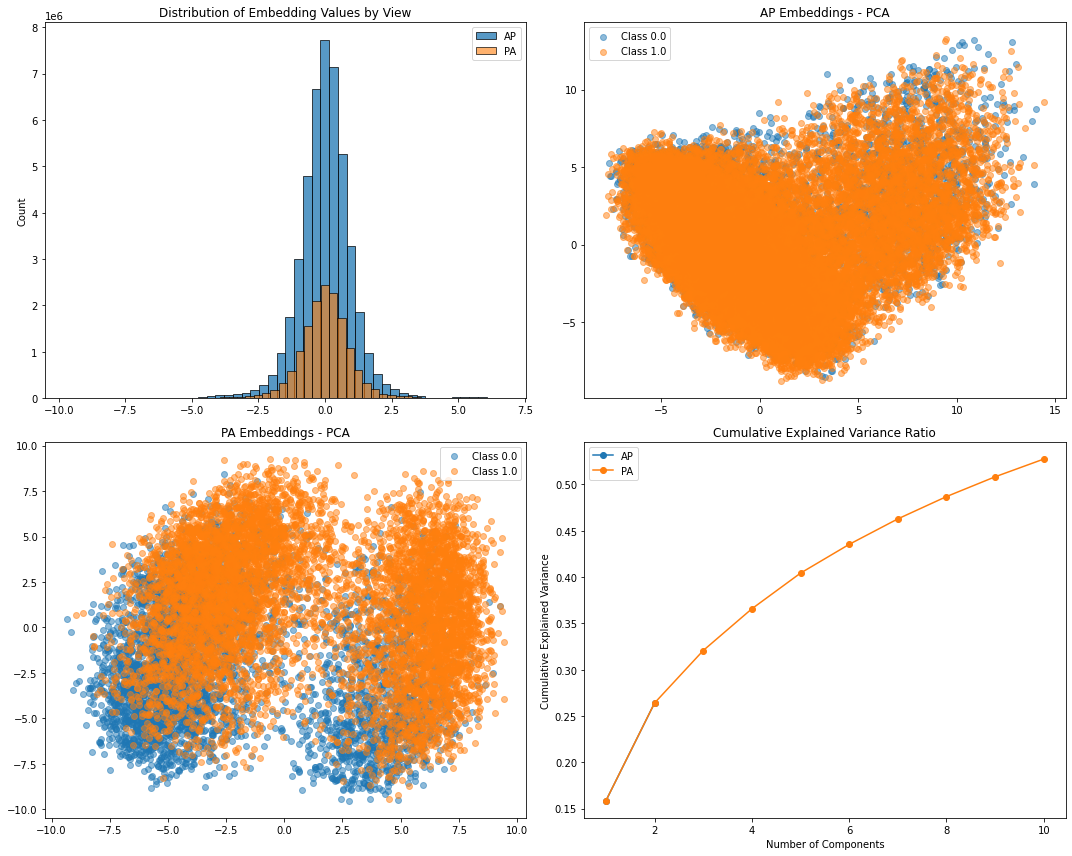

In [ ]:
from sklearn.manifold import TSNE


def analyze_embeddings_distribution(train_df, val_df, test_df, embedding_base_path):
    """Analyze embeddings"""
    print("\n=== Embedding Analysis for Processed Data ===")

    X_train_ap, y_train_ap = get_embeddings_and_labels(
        train_df[train_df['ViewCodeSequence_CodeMeaning'] == 'antero-posterior'],
        embedding_base_path
    )
    X_train_pa, y_train_pa = get_embeddings_and_labels(
        train_df[train_df['ViewCodeSequence_CodeMeaning'] == 'postero-anterior'],
        embedding_base_path
    )

    print("\nEmbedding Shapes:")
    print(f"AP Training embeddings: {X_train_ap.shape}")
    print(f"PA Training embeddings: {X_train_pa.shape}")

    # Basic statistics per view
    print("\nAP Embeddings Statistics:")
    print(f"Mean: {X_train_ap.mean():.4f}")
    print(f"Std: {X_train_ap.std():.4f}")
    print(f"Min: {X_train_ap.min():.4f}")
    print(f"Max: {X_train_ap.max():.4f}")

    print("\nPA Embeddings Statistics:")
    print(f"Mean: {X_train_pa.mean():.4f}")
    print(f"Std: {X_train_pa.std():.4f}")
    print(f"Min: {X_train_pa.min():.4f}")
    print(f"Max: {X_train_pa.max():.4f}")

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Distribution of embedding values
    sns.histplot(X_train_ap.flatten(), bins=50, ax=axes[0,0], label='AP')
    sns.histplot(X_train_pa.flatten(), bins=50, ax=axes[0,0], label='PA', alpha=0.6)
    axes[0,0].set_title('Distribution of Embedding Values by View')
    axes[0,0].legend()

    # PCA visualization for AP
    pca = PCA(n_components=2)
    ap_2d = pca.fit_transform(X_train_ap)

    for label in np.unique(y_train_ap):
        mask = y_train_ap == label
        axes[0,1].scatter(ap_2d[mask, 0], ap_2d[mask, 1],
                         alpha=0.5, label=f'Class {label}')
    axes[0,1].set_title('AP Embeddings - PCA')
    axes[0,1].legend()

    # PCA visualization for PA
    pca = PCA(n_components=2)
    pa_2d = pca.fit_transform(X_train_pa)

    for label in np.unique(y_train_pa):
        mask = y_train_pa == label
        axes[1,0].scatter(pa_2d[mask, 0], pa_2d[mask, 1],
                         alpha=0.5, label=f'Class {label}')
    axes[1,0].set_title('PA Embeddings - PCA')
    axes[1,0].legend()

    # Explained variance ratio
    var_ratio_ap = pca.explained_variance_ratio_[:10]
    axes[1,1].plot(range(1, len(var_ratio_ap) + 1),
                   np.cumsum(var_ratio_ap),
                   marker='o', label='AP')

    pca = PCA(n_components=10)
    pca.fit(X_train_pa)
    var_ratio_pa = pca.explained_variance_ratio_
    axes[1,1].plot(range(1, len(var_ratio_pa) + 1),
                   np.cumsum(var_ratio_pa),
                   marker='o', label='PA')

    axes[1,1].set_title('Cumulative Explained Variance Ratio')
    axes[1,1].set_xlabel('Number of Components')
    axes[1,1].set_ylabel('Cumulative Explained Variance')
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

# Analyze embeddings
analyze_embeddings_distribution(train_df, val_df, test_df, embedding_base_path)



In [ ]:
def create_model():
    return LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    )


def plot_metrics(model, X, y, title=""):
    # Get predictions and probabilities
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    # Compute metrics
    auc_score = roc_auc_score(y, y_prob)
    avg_precision = average_precision_score(y, y_prob)

    # Create figure with subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y, y_prob)
    axs[0].plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
    axs[0].plot([0, 1], [0, 1], 'k--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title(f'{title} ROC Curve')
    axs[0].legend()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y, y_prob)
    axs[1].plot(recall, precision, label=f'AP = {avg_precision:.3f}')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title(f'{title} Precision-Recall Curve')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    # Print detailed metrics
    print(f"\n{title} Metrics:")
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    print(f"AUC-ROC Score: {auc_score:.3f}")
    print(f"Average Precision Score: {avg_precision:.3f}")

    return auc_score

class ChestXRayTester:
    def __init__(self, model_ap, model_pa, df_labels):
        self.model_ap = model_ap
        self.model_pa = model_pa

        self.embedding_base_path = "/home/aaajiba/.cache/kagglehub/datasets/mohammadrezachavoshi/mimic-pth/versions/1/pth_embeddings"

        self.df = df_labels[['subject_id', 'study_id', 'dicom_id',
                           'ViewCodeSequence_CodeMeaning', 'Cardiomegaly']].copy()

        #self.print_data_info()
        self.find_good_test_cases()

    def find_good_test_cases(self):
        """Find and print information about suitable test cases"""
        #logger.info("\nFinding suitable test cases...")

        # Get patients with labels
        step1_df = self.df[self.df['Cardiomegaly'].notna()]
        #logger.info(f"Images with non-NaN labels: {len(step1_df)}")

        step2_df = step1_df[step1_df['Cardiomegaly'] != -1]
        #logger.info(f"Images with certain labels (0 or 1): {len(step2_df)}")

        # Group by patient
        patient_groups = step2_df.groupby('subject_id')
        #logger.info(f"Number of patients with valid labels: {len(patient_groups)}")

        # Look for patients with at least 1 image
        good_patients = []
        for subject_id, group in patient_groups:
            views = group['ViewCodeSequence_CodeMeaning'].value_counts()
            if len(group) >= 1:  # At least 1 image
                good_patients.append({
                    'patient_id': subject_id,
                    'total_images': len(group),
                    'cardiomegaly_ratio': group['Cardiomegaly'].mean(),
                    'views': views.to_dict()
                })

        #logger.info(f"Found {len(good_patients)} patients with at least 1 image")

        if good_patients:
            # Sort by number of images, descending
            good_patients.sort(key=lambda x: x['total_images'], reverse=True)

            #logger.info("\nTop 5 patients by number of images:")
            for patient in good_patients[:5]:
                pass
                #logger.info(f"\nPatient ID: {patient['patient_id']}")
                #logger.info(f"Total labeled images: {patient['total_images']}")
                #logger.info(f"Cardiomegaly ratio: {patient['cardiomegaly_ratio']:.2f}")
                #logger.info(f"View distribution: {patient['views']}")

        return good_patients


    def process_image(self, image_path):
        try:
            dicom_id = os.path.basename(image_path).split(".")[0]
            #logger.info(f"\nProcessing image: {dicom_id}")

            # Check if dicom_id exists in dataset
            matching_rows = self.df[self.df['dicom_id'] == dicom_id]
            if matching_rows.empty:
                logger.warning(f"Image {dicom_id} not found in metadata")
                return None

            #logger.info(f"View type: {matching_rows['ViewCodeSequence_CodeMeaning'].iloc[0]}")
            #logger.info(f"Cardiomegaly status: {matching_rows['Cardiomegaly'].iloc[0]}")

            # Get embedding
            parts = image_path.split('/')
            embedding_path = os.path.join(
                self.embedding_base_path,
                'files',
                parts[-3][:3],
                parts[-3],
                parts[-2],
                f"{dicom_id}.pth"
            )

            if not os.path.exists(embedding_path):
                #logger.warning(f"No embedding found for {dicom_id}")
                return None

            embedding = torch.load(embedding_path, weights_only=True).float()
            embedding = (embedding - embedding.mean()) / embedding.std()

            # Load image for visualization
            image = Image.open(image_path).convert('RGB')
            image = transforms.Resize((224, 224))(image)
            image = transforms.ToTensor()(image)

            #logger.info(f"Successfully processed image {dicom_id}")
            return {'dicom_id': dicom_id,
                   'embedding': embedding,
                   'image': image}
        except Exception as e:
            #logger.error(f"Error processing image {image_path}: {e}")
            return None


    def find_valid_images(self, base_dir, view_type):
        valid_images = []

        for root, _, files in os.walk(base_dir):
            for file in files:
                if file.endswith(".jpg"):
                    image_path = os.path.join(root, file)
                    processed = self.process_image(image_path)

                    if processed is None:
                        continue

                    # Check if image matches required view type
                    row = self.df[
                        (self.df['dicom_id'] == processed['dicom_id']) &
                        (self.df['ViewCodeSequence_CodeMeaning'] ==
                         ('antero-posterior' if view_type == 'AP' else 'postero-anterior')) &
                        (self.df['Cardiomegaly'].notna()) &  # Exclude NaN
                        (self.df['Cardiomegaly'] != -1)  # Exclude uncertain cases
                    ]

                    if not row.empty:
                        processed['actual_label'] = row['Cardiomegaly'].iloc[0]
                        valid_images.append(processed)
                    else:
                        pass

        return valid_images if valid_images else []


    def create_visualization(self, ap_folder, pa_folder):
        # Get valid images
        ap_images = self.find_valid_images(ap_folder, 'AP')
        pa_images = self.find_valid_images(pa_folder, 'PA')

        #logger.info(f"Found {len(ap_images)} valid AP images and {len(pa_images)} valid PA images")

        # Early return if no valid images
        if not ap_images and not pa_images:
            #logger.warning("No valid images found to visualize")
            return None

        # Calculate grid dimensions
        IMAGES_PER_ROW = 2
        ap_rows = math.ceil(len(ap_images) / IMAGES_PER_ROW) if ap_images else 0
        pa_rows = math.ceil(len(pa_images) / IMAGES_PER_ROW) if pa_images else 0
        total_rows = ap_rows + pa_rows

        # Create figure
        fig = plt.figure(figsize=(15, 8 * total_rows))

        # Process AP images
        if ap_images:
            plt.figtext(0.5, 0.98, "AP View Results", ha='center', fontsize=16, fontweight='bold')
            for i, img_data in enumerate(ap_images):
                ax = plt.subplot(total_rows, IMAGES_PER_ROW, i + 1)

                # For logistic regression, embedding needs to be reshaped
                embedding_np = img_data['embedding'].cpu().numpy().reshape(1, -1)
                probability = self.model_ap.predict_proba(embedding_np)[0][1]
                predicted_label = int(probability > 0.5)
                is_correct = predicted_label == int(img_data['actual_label'])


                ax.imshow(img_data['image'].permute(1, 2, 0))
                ax.axis('off')

                for spine in ax.spines.values():
                    spine.set_color('green' if is_correct else 'red')
                    spine.set_linewidth(3)
                    spine.set_visible(True)

                result_text = "CORRECT" if is_correct else "INCORRECT"
                title = f"{result_text}\n"
                title += f"Pred: {'Cardiomegaly' if predicted_label else 'Normal'}\n"
                title += f"True: {'Cardiomegaly' if img_data['actual_label'] else 'Normal'}\n"
                title += f"Confidence: {probability:.2f}"

                ax.set_title(title, color='green' if is_correct else 'red',
                            fontweight='bold', pad=10, fontsize=12)

        # Process PA images
        if pa_images:
            pa_start = (ap_rows * IMAGES_PER_ROW) + 1

            # Only add divider if we have both AP and PA images
            if ap_images:
                plt.figtext(0.5, 0.52, "─" * 50, ha='center', fontsize=12)
                plt.figtext(0.5, 0.48, "PA View Results", ha='center', fontsize=16, fontweight='bold')
            else:
                plt.figtext(0.5, 0.98, "PA View Results", ha='center', fontsize=16, fontweight='bold')

            for i, img_data in enumerate(pa_images):
                ax = plt.subplot(total_rows, IMAGES_PER_ROW, pa_start + i)

                # For logistic regression, embedding needs to be reshaped
                embedding_np = img_data['embedding'].cpu().numpy().reshape(1, -1)
                probability = self.model_pa.predict_proba(embedding_np)[0][1]
                predicted_label = int(probability > 0.5)
                is_correct = predicted_label == int(img_data['actual_label'])


                ax.imshow(img_data['image'].permute(1, 2, 0))
                ax.axis('off')

                for spine in ax.spines.values():
                    spine.set_color('green' if is_correct else 'red')
                    spine.set_linewidth(3)
                    spine.set_visible(True)

                result_text = "CORRECT" if is_correct else "INCORRECT"
                title = f"{result_text}\n"
                title += f"Pred: {'Cardiomegaly' if predicted_label else 'Normal'}\n"
                title += f"True: {'Cardiomegaly' if img_data['actual_label'] else 'Normal'}\n"
                title += f"Confidence: {probability:.2f}"

                ax.set_title(title, color='green' if is_correct else 'red',
                            fontweight='bold', pad=10, fontsize=12)

        plt.tight_layout()
        plt.subplots_adjust(top=0.95, bottom=0.05, hspace=0.4)
        return fig

In [ ]:
def train_and_evaluate_models(df_labels):
    """Train and evaluate models for both AP and PA views"""
    # Define embedding path
    embedding_base_path = "/home/aaajiba/.cache/kagglehub/datasets/mohammadrezachavoshi/mimic-pth/versions/1/pth_embeddings"

    # Prepare data
    train_df, val_df, test_df = prepare_data(df_labels)

    # Print data splits info
    logger.info(f"Train set size: {len(train_df)}")
    logger.info(f"Validation set size: {len(val_df)}")
    logger.info(f"Test set size: {len(test_df)}")

    # Split by view
    train_ap = train_df[train_df['ViewCodeSequence_CodeMeaning'] == 'antero-posterior']
    train_pa = train_df[train_df['ViewCodeSequence_CodeMeaning'] == 'postero-anterior']
    val_ap = val_df[val_df['ViewCodeSequence_CodeMeaning'] == 'antero-posterior']
    val_pa = val_df[val_df['ViewCodeSequence_CodeMeaning'] == 'postero-anterior']

    # Get embeddings and labels
    logger.info("Loading AP embeddings...")
    X_train_ap, y_train_ap = get_embeddings_and_labels(train_ap, embedding_base_path)
    X_val_ap, y_val_ap = get_embeddings_and_labels(val_ap, embedding_base_path)

    logger.info("Loading PA embeddings...")
    X_train_pa, y_train_pa = get_embeddings_and_labels(train_pa, embedding_base_path)
    X_val_pa, y_val_pa = get_embeddings_and_labels(val_pa, embedding_base_path)

    # Train models
    logger.info("Training AP model...")
    model_ap = create_model()
    model_ap.fit(X_train_ap, y_train_ap)

    logger.info("Training PA model...")
    model_pa = create_model()
    model_pa.fit(X_train_pa, y_train_pa)

    # Evaluate models
    logger.info("\nAP Model Performance:")
    plot_metrics(model_ap, X_train_ap, y_train_ap, "AP Train")
    plot_metrics(model_ap, X_val_ap, y_val_ap, "AP Validation")

    logger.info("\nPA Model Performance:")
    plot_metrics(model_pa, X_train_pa, y_train_pa, "PA Train")
    plot_metrics(model_pa, X_val_pa, y_val_pa, "PA Validation")

    return model_ap, model_pa

def test_and_visualize_models(model_ap, model_pa, tester, ap_folder, pa_folder):
    """Test and visualize using the tester instance"""
    try:
        fig = tester.create_visualization(ap_folder, pa_folder)
        if fig is not None:
            plt.show()
            return fig
        else:
            logger.warning("No visualization created - no valid images found")
    except Exception as e:
        logger.error(f"Error in test_and_visualize_models: {e}")
        raise

def test_models(model_ap, model_pa, df_labels, ap_folder=None, pa_folder=None):
    """Test the models on specified image folders or find suitable test cases"""
    tester = ChestXRayTester(model_ap, model_pa, df_labels)

    if ap_folder is None or pa_folder is None:
        good_patients = tester.find_good_test_cases()
        if not good_patients:
            logger.warning("No suitable test patients found")
            return None

        test_patient = good_patients[0]['patient_id']
        base_path = "/opt/NAS3/CXR/MIMIC_CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/files"
        patient_prefix = f"p{str(test_patient)[:2]}"
        test_path = os.path.join(base_path, patient_prefix, f"p{test_patient}")

        if not os.path.exists(test_path):
            logger.error(f"Test path does not exist: {test_path}")
            return None

        ap_folder = test_path
        pa_folder = test_path

    # Run visualization
    return test_and_visualize_models(
        model_ap=model_ap,
        model_pa=model_pa,
        tester=tester,
        ap_folder=ap_folder,
        pa_folder=pa_folder
    )



2025-02-04 12:11:38,618 - INFO - Train set size: 45101
2025-02-04 12:11:38,619 - INFO - Validation set size: 9490
2025-02-04 12:11:38,620 - INFO - Test set size: 9452
2025-02-04 12:11:38,634 - INFO - Loading AP embeddings...
2025-02-04 12:12:06,976 - INFO - Loading PA embeddings...
2025-02-04 12:12:15,420 - INFO - Training AP model...
2025-02-04 12:12:51,250 - INFO - Training PA model...
2025-02-04 12:12:58,516 - INFO - 
AP Model Performance:


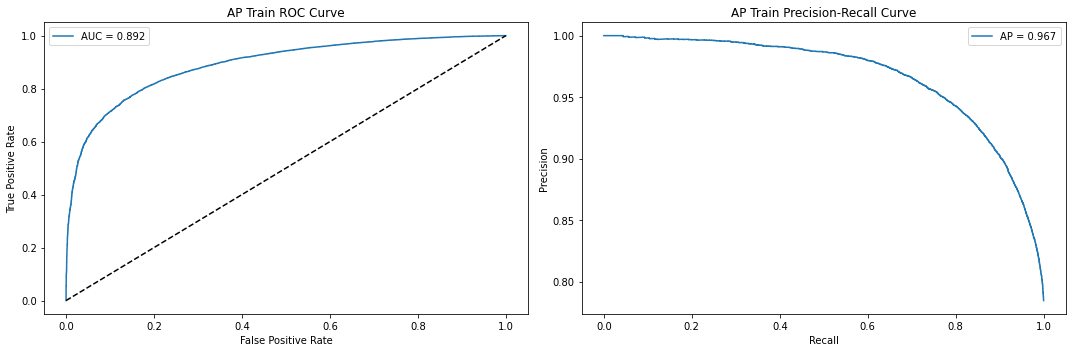


AP Train Metrics:
Confusion Matrix:
[[ 5998  1287]
 [ 5307 21223]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.82      0.65      7285
         1.0       0.94      0.80      0.87     26530

    accuracy                           0.80     33815
   macro avg       0.74      0.81      0.76     33815
weighted avg       0.85      0.80      0.82     33815

AUC-ROC Score: 0.892
Average Precision Score: 0.967


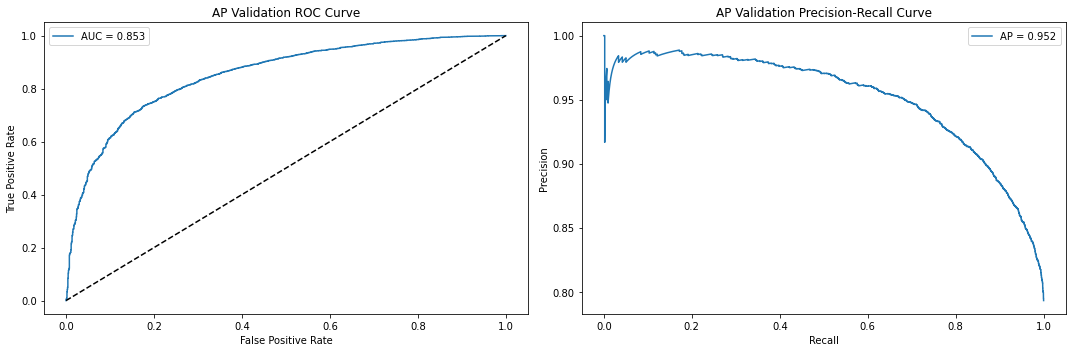

2025-02-04 12:13:04,547 - INFO - 
PA Model Performance:



AP Validation Metrics:
Confusion Matrix:
[[1119  348]
 [1236 4387]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.48      0.76      0.59      1467
         1.0       0.93      0.78      0.85      5623

    accuracy                           0.78      7090
   macro avg       0.70      0.77      0.72      7090
weighted avg       0.83      0.78      0.79      7090

AUC-ROC Score: 0.853
Average Precision Score: 0.952


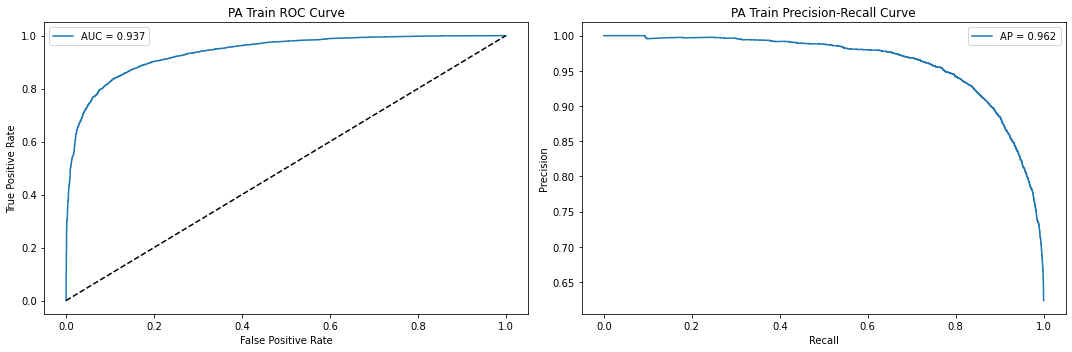


PA Train Metrics:
Confusion Matrix:
[[3635  529]
 [1016 5885]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.87      0.82      4164
         1.0       0.92      0.85      0.88      6901

    accuracy                           0.86     11065
   macro avg       0.85      0.86      0.85     11065
weighted avg       0.87      0.86      0.86     11065

AUC-ROC Score: 0.937
Average Precision Score: 0.962


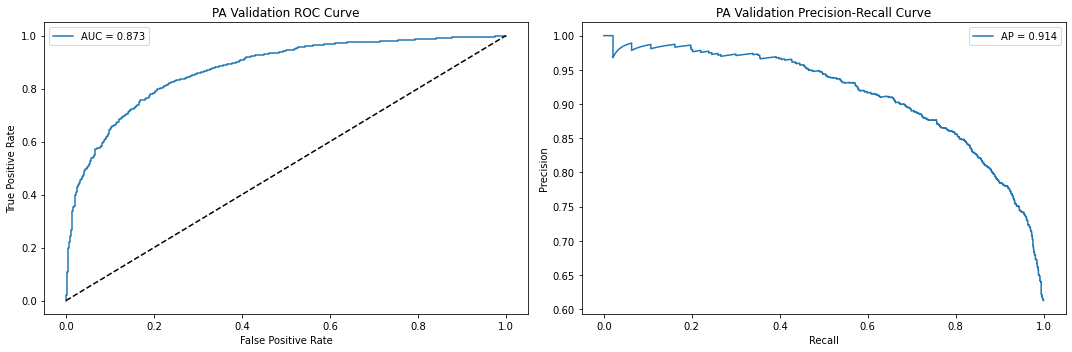


PA Validation Metrics:
Confusion Matrix:
[[ 709  203]
 [ 277 1165]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.78      0.75       912
         1.0       0.85      0.81      0.83      1442

    accuracy                           0.80      2354
   macro avg       0.79      0.79      0.79      2354
weighted avg       0.80      0.80      0.80      2354

AUC-ROC Score: 0.873
Average Precision Score: 0.914


In [ ]:
# Train models
model_ap, model_pa = train_and_evaluate_models(df_labels)


2025-02-04 12:13:17,597 - WARNING - Image 1abcab3c-7520fdda-18b89790-32517fbb-83794f4d not found in metadata
2025-02-04 12:13:19,944 - WARNING - Image f251dcb8-1324d799-7f9746d7-cef9b979-f9ad2457 not found in metadata
2025-02-04 12:13:27,062 - WARNING - Image d718b03a-d3a76c94-1b9190ca-4b593a92-7d9fa91d not found in metadata
2025-02-04 12:13:29,982 - WARNING - Image 69ff5963-841d8a4c-3e4a4a52-8730422b-86dcaf72 not found in metadata
2025-02-04 12:13:30,680 - WARNING - Image 47c0b3cb-292745ac-daed7371-3738f5fb-168e2aeb not found in metadata
2025-02-04 12:13:30,694 - WARNING - Image 8d1b48e5-17b3bec0-2e059154-daba8db3-05ccd343 not found in metadata
2025-02-04 12:13:31,134 - WARNING - Image 62613b6a-2c57c4e9-375a7f07-5206d9e6-5a8bb56d not found in metadata
2025-02-04 12:13:31,148 - WARNING - Image cd073754-f0fda5e2-b07989bd-57af1704-4a34720c not found in metadata
2025-02-04 12:13:33,928 - WARNING - Image 7ad85d51-799cef24-dd85fc99-1c9cdea7-79b2a061 not found in metadata
2025-02-04 12:13:46

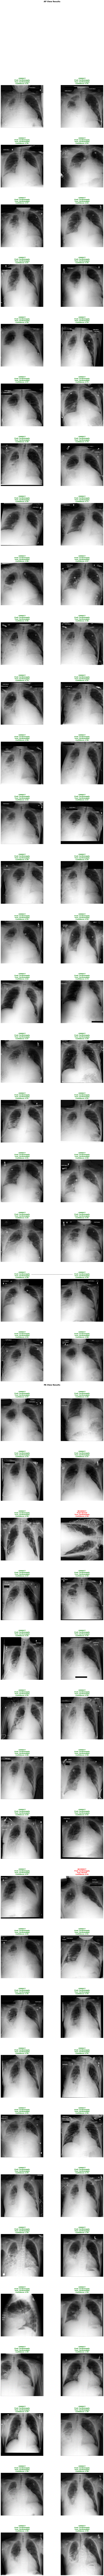

In [ ]:
# Test on specific folders
fig = test_models(
    model_ap=model_ap,
    model_pa=model_pa,
    df_labels=df_labels,
    # ap_folder="path/to/ap/images",
    # pa_folder="path/to/pa/images"
)

In [ ]:
def create_grouped_visualization(self, ap_folder, pa_folder):
    """Visualize predictions grouped by correctness for AP/PA views with patient info"""
    # Get valid images
    ap_images = self.find_valid_images(ap_folder, 'AP')
    pa_images = self.find_valid_images(pa_folder, 'PA')

    # Get patient information
    patient_info = {
        'id': None,
        'ap_path': ap_folder,
        'pa_path': pa_folder
    }

    # Try to extract patient ID from first available image
    for img in ap_images + pa_images:
        if img:
            row = self.df[self.df['dicom_id'] == img['dicom_id']].iloc[0]
            patient_info['id'] = row['subject_id']
            break

    # Print patient information
    print(f"\n{'='*50}")
    print(f"Patient ID: {patient_info['id']}")
    print(f"AP Folder: {patient_info['ap_path']}")
    print(f"PA Folder: {patient_info['pa_path']}")
    print(f"{'='*50}")

    # Early return if no valid images
    if not ap_images and not pa_images:
        print("No valid images found for visualization")
        return None

    # Process predictions and group by correctness
    def process_group(images, model):
        grouped = {'correct': [], 'incorrect': []}
        for img in images:
            embedding_np = img['embedding'].cpu().numpy().reshape(1, -1)
            probability = model.predict_proba(embedding_np)[0][1]
            predicted = int(probability > 0.5)
            actual = int(img['actual_label'])

            img['predicted'] = predicted
            img['probability'] = probability
            img['correct'] = predicted == actual

            key = 'correct' if img['correct'] else 'incorrect'
            grouped[key].append(img)
        return grouped

    # Process AP and PA images
    ap_groups = process_group(ap_images, self.model_ap) if ap_images else {}
    pa_groups = process_group(pa_images, self.model_pa) if pa_images else {}

    # Create visualization
    IMAGES_PER_ROW = 2
    sections = [
        ('AP Correct', ap_groups.get('correct', [])),
        ('AP Incorrect', ap_groups.get('incorrect', [])),
        ('PA Correct', pa_groups.get('correct', [])),
        ('PA Incorrect', pa_groups.get('incorrect', []))
    ]

    # Calculate rows needed
    rows = 0
    for title, group in sections:
        if group:
            rows += math.ceil(len(group) / IMAGES_PER_ROW)

    if rows == 0:
        print("No valid predictions to display")
        return None

    # Create figure
    fig = plt.figure(figsize=(15, 5 * rows))
    plt.suptitle(f"Patient Analysis - ID: {patient_info['id']}",
                y=0.98, fontsize=16, fontweight='bold')

    current_position = 1
    for section_idx, (title, group) in enumerate(sections):
        if not group:
            continue

        num_images = len(group)
        num_rows = math.ceil(num_images / IMAGES_PER_ROW)

        for i in range(num_images):
            ax = plt.subplot(rows, IMAGES_PER_ROW, current_position)
            img_data = group[i]

            # Display image
            ax.imshow(img_data['image'].permute(1, 2, 0))
            ax.axis('off')

            # Set border style
            border_color = 'green' if img_data['correct'] else 'red'
            for spine in ax.spines.values():
                spine.set_color(border_color)
                spine.set_linewidth(3)
                spine.set_visible(True)

            # Set title
            status = "CORRECT" if img_data['correct'] else "INCORRECT"
            pred = 'Cardiomegaly' if img_data['predicted'] else 'Normal'
            true = 'Cardiomegaly' if img_data['actual_label'] else 'Normal'
            ax.set_title(
                f"{status} | {title}\n"
                f"Pred: {pred} ({img_data['probability']:.2f})\n"
                f"True: {true}",
                color=border_color, fontsize=10, pad=12
            )

            current_position += 1

    plt.tight_layout()
    plt.subplots_adjust(top=0.93, hspace=0.4)
    return fig

# Add to ChestXRayTester class
ChestXRayTester.create_grouped_visualization = create_grouped_visualization

def test_models_grouped(model_ap, model_pa, df_labels, ap_folder=None, pa_folder=None):
    """Test models with grouped visualization"""
    tester = ChestXRayTester(model_ap, model_pa, df_labels)

    # Find test patient if no folders provided
    if ap_folder is None or pa_folder is None:
        good_patients = tester.find_good_test_cases()
        if not good_patients:
            print("No suitable test patients found")
            return

        test_patient = good_patients[0]['patient_id']
        base_path = "/opt/NAS3/CXR/MIMIC_CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/files"
        patient_prefix = f"p{str(test_patient)[:2]}"
        test_path = os.path.join(base_path, patient_prefix, f"p{test_patient}")

        ap_folder = pa_folder = test_path  # Use same folder for both views

    # Create and show visualization
    try:
        fig = tester.create_grouped_visualization(ap_folder, pa_folder)
        if fig:
            plt.show()
        else:
            print("No visualization created - check input folders")
    except Exception as e:
        print(f"Error during visualization: {str(e)}")